## Data Science Classification Project: Predicting The Quality of Wine

### Loading Required Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from lightgbm import LGBMClassifier
from bayes_opt import BayesianOptimization
from bayes_opt.util import Colours

In [3]:
data = pd.read_csv(r'E:/Data_Sets/winequality.csv')

# Exploratory Data Analysis

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [5]:
data.isnull().sum()

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

In [6]:
data['type'].unique()

array(['white', 'red'], dtype=object)

In [7]:
A = pd.get_dummies(data['type'])

In [8]:
A.head()

,red,white
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [9]:
d1 = pd.concat([A,data], axis=1)

In [10]:
d1.head()

,red,white,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0,1,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,0,1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,0,1,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,0,1,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,0,1,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [11]:
d1.drop(['type'], inplace=True, axis=1)

In [12]:
d1.head()

,red,white,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0,1,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,0,1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,0,1,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,0,1,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,0,1,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [13]:
d2 = d1.dropna()
d2.isnull().sum()

red                     0
white                   0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [14]:
d2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6463 entries, 0 to 6496
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   red                   6463 non-null   uint8  
 1   white                 6463 non-null   uint8  
 2   fixed acidity         6463 non-null   float64
 3   volatile acidity      6463 non-null   float64
 4   citric acid           6463 non-null   float64
 5   residual sugar        6463 non-null   float64
 6   chlorides             6463 non-null   float64
 7   free sulfur dioxide   6463 non-null   float64
 8   total sulfur dioxide  6463 non-null   float64
 9   density               6463 non-null   float64
 10  pH                    6463 non-null   float64
 11  sulphates             6463 non-null   float64
 12  alcohol               6463 non-null   float64
 13  quality               6463 non-null   int64  
dtypes: float64(11), int64(1), uint8(2)
memory usage: 669.0 KB


In [15]:
d2.describe()

,red,white,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000
mean,0.246480,0.753520,7.217755,0.339589,0.318758,5.443958,0.056056,30.516865,115.694492,0.994698,3.218332,0.531150,10.492825,5.818505
std,0.430995,0.430995,1.297913,0.164639,0.145252,4.756852,0.035076,17.758815,56.526736,0.003001,0.160650,0.148913,1.193128,0.873286
min,0.000000,0.000000,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,0.000000,1.000000,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992330,3.110000,0.430000,9.500000,5.000000
50%,0.000000,1.000000,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,0.000000,1.000000,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.997000,3.320000,0.600000,11.300000,6.000000
max,1.000000,1.000000,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


Text(0, 0.5, 'Frequency')

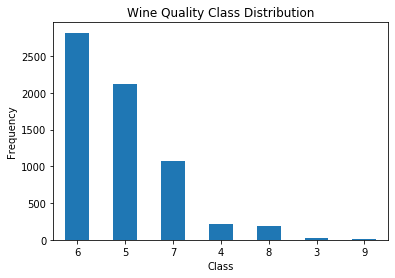

In [16]:
count_classes = pd.value_counts(d2['quality'], sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Wine Quality Class Distribution")

plt.xlabel("Class")

plt.ylabel("Frequency")

# Feature Engineering

In [17]:
d2['quality'].unique()

array([6, 5, 7, 8, 4, 3, 9], dtype=int64)

### Making binary classificaion for the response variable.Dividing wine as good and bad by giving the limit for the quality

In [18]:
bins = (2, 6, 9)
group_names = ['bad', 'good']
d2['quality'] = pd.cut(d2['quality'], bins = bins, labels = group_names)

C:\Users\AAA\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
d2.head()

,red,white,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0,1,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,bad
1,0,1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,bad
2,0,1,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,bad
3,0,1,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,bad
4,0,1,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,bad


In [20]:
d2.isnull().sum()

red                     0
white                   0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [21]:
from sklearn.preprocessing import LabelEncoder

In [22]:
label_quality = LabelEncoder()

In [23]:
d2['quality'] = label_quality.fit_transform(d2['quality'])

C:\Users\AAA\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [24]:
d2.head()

,red,white,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0,1,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,0
1,0,1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,0
2,0,1,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,0
3,0,1,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,0
4,0,1,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,0


Text(0, 0.5, 'Frequency')

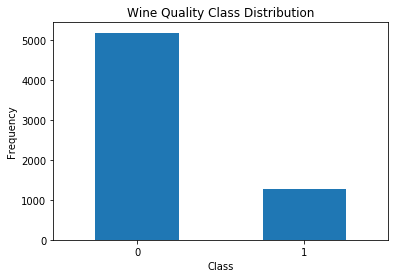

In [25]:
count_classes = pd.value_counts(d2['quality'], sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Wine Quality Class Distribution")

plt.xlabel("Class")

plt.ylabel("Frequency")

### RandomOverSampler to handle imbalanced data

In [26]:
from collections import Counter
from imblearn.combine import SMOTETomek
os =  SMOTETomek(sampling_strategy=0.5)

In [27]:
x2, y2 = os.fit_sample(d2.iloc[:,0:13], d2.iloc[:,-1])

In [28]:
x2.shape, y2.shape

((7570, 13), (7570,))

In [29]:
print('Original dataset shape {}'.format(Counter(d2.iloc[:,-1])))
print('Resampled dataset shape {}'.format(Counter(y2)))

Original dataset shape Counter({0: 5192, 1: 1271})
Resampled dataset shape Counter({0: 5083, 1: 2487})


Text(0, 0.5, 'Frequency')

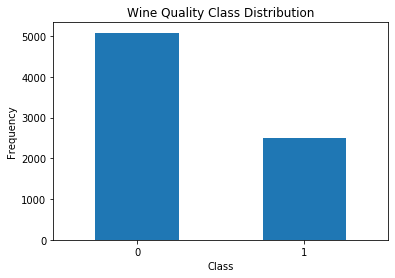

In [30]:
count_classes = pd.value_counts(y2, sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Wine Quality Class Distribution")

plt.xlabel("Class")

plt.ylabel("Frequency")

In [31]:
df = pd.concat([x2,y2], axis=1)
df2 = df.sample(frac=1)
df2.head()

,red,white,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
5736,1,0,7.1,0.59,0.00,2.1,0.091,9.0,14.0,0.99488,3.42,0.55,11.5,1
4735,1,0,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.99780,3.51,0.56,9.4,0
2032,0,1,6.5,0.22,0.25,17.1,0.050,44.0,138.0,1.00010,3.30,0.37,8.8,0
5361,1,0,10.7,0.43,0.39,2.2,0.106,8.0,32.0,0.99860,2.89,0.50,9.6,0
4161,0,1,6.2,0.26,0.29,2.0,0.036,16.0,87.0,0.99081,3.33,0.61,11.8,0


In [32]:
x_train = df2.iloc[:,:13].values
y_train = df2.iloc[:,-1].values

### Bayesian Optimization :
### Bayesian optimization works by constructing a posterior distribution of functions (gaussian process) that best describes the function you want to optimize. As the number of observations grows, the posterior distribution improves, and the algorithm becomes more certain of which regions in parameter space are worth exploring and which are not, as seen in the picture below.

## Hyperparameter tuning of XGBoostingClassifier using Bayesian optimization

In [33]:
from sklearn.metrics import f1_score

In [34]:
def xgb_cv(n_estimators, max_depth, gamma, min_child_weight, subsample, data, target):
    estimator = XGBClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                gamma=gamma,
                min_child_weight=min_child_weight,
                subsample=subsample,
                random_state=2
    )
    cval = cross_val_score(estimator, data, target, scoring='f1_micro', cv=5)
    
    return cval.mean()

In [35]:
def optimize_xgb(data, target):
    def xgb_crossval(n_estimators, max_depth, gamma, min_child_weight, subsample):
        return xgb_cv(
            n_estimators=int(n_estimators),
            max_depth=int(max_depth),
            gamma=gamma,
            min_child_weight=min_child_weight,
            subsample=subsample,
            data=data,
            target=target,
        )
    optimizer = BayesianOptimization(
            f=xgb_crossval,
            pbounds={
                "n_estimators":(100,550),
                "max_depth": (1,20),
                "gamma":(0,10),
                "min_child_weight":(0,10),
                "subsample":(0.8,1.0)
                },
            random_state=1234,
            verbose=2
      )
    optimizer.maximize(n_iter=15 , init_points=10)
    
    
    print('Final Result:', optimizer.max)

In [36]:
print(Colours.red("--- Optimizing XGBoost ---"))
optimize_xgb(x_train, y_train)

--- Optimizing XGBoost ---
|   iter    |  target   |   gamma   | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  1        |  0.8982   |  1.915    |  12.82    |  4.377    |  453.4    |  0.956    |
|  2        |  0.8892   |  2.726    |  6.253    |  8.019    |  531.2    |  0.9752   |
|  3        |  0.8904   |  3.578    |  10.52    |  6.835    |  420.7    |  0.8741   |
|  4        |  0.8857   |  5.612    |  10.56    |  0.1377   |  447.8    |  0.9765   |
|  5        |  0.8931   |  3.649    |  12.69    |  0.7538   |  266.0    |  0.9866   |
|  6        |  0.8721   |  6.514    |  8.547    |  7.887    |  242.6    |  0.9136   |
|  7        |  0.8614   |  8.691    |  9.287    |  8.021    |  164.7    |  0.9409   |
|  8        |  0.8572   |  7.046    |  5.157    |  9.249    |  299.0    |  0.9819   |
|  9        |  0.9049   |  0.5981   |  4.501    |  0.4736   |  403.7    |  0.9189   |
|  10       |  0.7993   |  

## Hyperparameter tuning of ExtratreesClassifier using Bayesian optimization

In [37]:
def etc_cv(n_estimators, min_samples_split, max_features, data, target):
    estimator = ExtraTreesClassifier(
            n_estimators=n_estimators,
            min_samples_split=min_samples_split,
            max_features=max_features,
            random_state=2,
            n_jobs=-1
    )
    cval = cross_val_score(estimator, data, target, scoring='f1_micro', cv=5)
    
    return cval.mean()

In [38]:
def optimize_etc(data, target):
    def etc_crossval(n_estimators, min_samples_split, max_features):
        return etc_cv(
                n_estimators=int(n_estimators),
                min_samples_split=int(min_samples_split),
                max_features=max(min(max_features, 0.999), 1e-3),
                data=data,
                target=target,
                )
    optimizer = BayesianOptimization(
        f=etc_crossval,
        pbounds={
            "n_estimators":(100,500),
            "min_samples_split":(2,25),
            "max_features": (0.1,0.9)
        },
        random_state=42,
        verbose=2
    )
    optimizer.maximize(n_iter=15, init_points=5)
    
    print("Final result:", optimizer.max)

In [39]:
print(Colours.yellow("--- Optimizing Extra Trees ---"))
optimize_etc(x_train, y_train)

--- Optimizing Extra Trees ---
|   iter    |  target   | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------
|  1        |  0.8679   |  0.3996   |  23.87    |  392.8    |
|  2        |  0.9041   |  0.5789   |  5.588    |  162.4    |
|  3        |  0.8506   |  0.1465   |  21.92    |  340.4    |
|  4        |  0.9096   |  0.6665   |  2.473    |  488.0    |
|  5        |  0.9038   |  0.766    |  6.884    |  172.7    |
|  6        |  0.8717   |  0.9      |  25.0     |  100.0    |
|  7        |  0.9092   |  0.4978   |  2.522    |  488.9    |
|  8        |  0.8424   |  0.1      |  25.0     |  463.2    |
|  9        |  0.8613   |  0.27     |  24.21    |  205.4    |
|  10       |  0.8737   |  0.9      |  25.0     |  159.3    |
|  11       |  0.8785   |  0.9      |  22.43    |  500.0    |
|  12       |  0.907    |  0.4086   |  2.194    |  136.9    |
|  13       |  0.9083   |  0.5802   |  2.074    |  272.0    |
|  14       |  0.8443   |  0.1      |  

In [47]:
etc = ExtraTreesClassifier(n_estimators=int(423.06736935956917),
                         min_samples_split=int(2.05509382243),
                         max_features=0.25444307353196416,
                         n_jobs = -1,
                         random_state = 42)

## Hyperparameter tuning of RandomForestClassifier using Bayesian optimization

In [40]:
def rfc_cv(n_estimators, min_samples_split, max_features, data, target):
    estimator = RandomForestClassifier(
            n_estimators=n_estimators,
            min_samples_split=min_samples_split,
            max_features=max_features,
            random_state=42,
            n_jobs=-1
    )
    cval = cross_val_score(estimator, data, target, scoring='f1_micro', cv=5)
    
    return cval.mean()

In [41]:
def optimize_rfc(data, target):
    def rfc_crossval(n_estimators, min_samples_split, max_features):
        return rfc_cv(
            n_estimators=int(n_estimators),
            min_samples_split=int(min_samples_split),
            max_features=max(min(max_features, 0.9), 1e-3),
            data=data,
            target=target,
            )
    optimizer = BayesianOptimization(
        f=rfc_crossval,
        pbounds={
            "n_estimators":(100,700),
            "min_samples_split":(2,25),
            "max_features":(0.1,0.9),
        },
        random_state=1234,
        verbose=2
    )
    optimizer.maximize(n_iter=15, init_points=5)
    
    print("Final result:", optimizer.max)

In [42]:
print(Colours.green("--- Optimizing Random Forest ---"))
optimize_rfc(x_train, y_train)

--- Optimizing Random Forest ---
|   iter    |  target   | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------
|  1        |  0.8808   |  0.2532   |  16.31    |  362.6    |
|  2        |  0.8806   |  0.7283   |  19.94    |  263.6    |
|  3        |  0.8774   |  0.3212   |  20.44    |  674.9    |
|  4        |  0.8926   |  0.8007   |  10.23    |  400.6    |
|  5        |  0.8814   |  0.6468   |  18.39    |  322.2    |
|  6        |  0.8955   |  0.8106   |  9.451    |  400.2    |
|  7        |  0.8947   |  0.5014   |  8.574    |  397.8    |
|  8        |  0.8985   |  0.7779   |  5.451    |  400.9    |
|  9        |  0.8979   |  0.1      |  4.846    |  406.3    |
|  10       |  0.9017   |  0.7873   |  2.949    |  412.2    |
|  11       |  0.8952   |  0.1333   |  6.863    |  416.4    |
|  12       |  0.8946   |  0.5044   |  8.445    |  410.7    |
|  13       |  0.9022   |  0.5181   |  2.067    |  424.5    |
|  14       |  0.902    |  0.4638   |

## Hyperparameter tuning of ExtremeGradientBoosting and RandomForest Classifier using Bayesian optimization

In [43]:
def xgb_cv(n_estimators, max_depth, gamma, min_child_weight, subsample, data, targets):
    estimator = XGBRFClassifier(
        n_estimators=n_estimators,
        max_depth = max_depth,
        gamma = gamma,
        min_child_weight=min_child_weight,
        subsample = subsample,
        random_state = 2,
    )
    cval = cross_val_score(estimator, data, targets,
                           scoring='f1_micro', cv=5)
    return cval.mean()

In [44]:
def optimize_xgb(data, targets):
    def xgb_crossval(n_estimators, max_depth, gamma, min_child_weight, subsample):
        return xgb_cv(
            n_estimators=int(n_estimators),
            max_depth = int(max_depth),
            gamma = gamma,
            min_child_weight=min_child_weight,
            subsample=subsample,
            data=data,
            targets=targets,
        )

    optimizer = BayesianOptimization(
        f=xgb_crossval,
        pbounds={
            "n_estimators": (100, 550),
            "max_depth": (6,15),
            "gamma": (0,10),
            "min_child_weight": (0,10),
            "subsample": (0.8,1.0)
        },
        random_state=1234,
        verbose=2
    )
    optimizer.maximize(n_iter=15, init_points=5)

    print("Final result:", optimizer.max)

In [45]:
print(Colours.red("--- Optimizing XGBoost RandomForest ---"))
optimize_xgb(x_train, y_train)

--- Optimizing XGBoost RandomForest ---
|   iter    |  target   |   gamma   | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------
|  1        |  0.8461   |  1.915    |  11.6     |  4.377    |  453.4    |  0.956    |
|  2        |  0.8225   |  2.726    |  8.488    |  8.019    |  531.2    |  0.9752   |
|  3        |  0.8326   |  3.578    |  10.51    |  6.835    |  420.7    |  0.8741   |
|  4        |  0.8654   |  5.612    |  10.53    |  0.1377   |  447.8    |  0.9765   |
|  5        |  0.8686   |  3.649    |  11.54    |  0.7538   |  266.0    |  0.9866   |
|  6        |  0.8266   |  5.153    |  7.633    |  3.77     |  134.2    |  0.8525   |
|  7        |  0.8701   |  6.275    |  11.11    |  0.3784   |  448.7    |  0.9131   |
|  8        |  0.8478   |  10.0     |  15.0     |  1.486    |  447.0    |  0.8      |
|  9        |  0.8384   |  8.813    |  8.254    |  0.0      |  451.5    |  0.8009   |
|  10       | 

## So from the accuracies (f1_score) of each of the Ensembling Techniques the ExtraTreesClassifier gives the best accuracy that is the best f1_score value and hence its my final model 


## Now checking the model performance by plotting the Learning Curve
### Metric Used : 'f1_micro' - Calculate metrics globally by counting the total true positives, false negatives and false positives 

###  'f1_micro' score reaches its best value at 1 and worst score at 0.

In [48]:
from sklearn.model_selection import learning_curve

In [49]:
train_sizes, train_scores, valid_scores = learning_curve(
etc , x_train, y_train, train_sizes=np.linspace(0.01, 1.0, 6), scoring='f1_micro', cv=5)

In [50]:
train_scores_mean = -train_scores.mean(axis = 1)
valid_scores_mean = -valid_scores.mean(axis = 1)
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean valid scores\n\n',pd.Series(valid_scores_mean, index = train_sizes))

Mean training scores

 60     -1.0
1259   -1.0
2458   -1.0
3657   -1.0
4856   -1.0
6056   -1.0
dtype: float64

 --------------------

Mean valid scores

 60     -0.725363
1259   -0.831704
2458   -0.870145
3657   -0.883091
4856   -0.900132
6056   -0.909511
dtype: float64


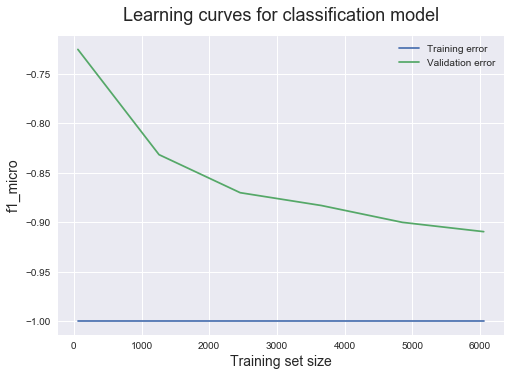

In [51]:
plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, valid_scores_mean, label = 'Validation error')
plt.ylabel('f1_micro', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for classification model', fontsize = 18, y = 1.03)
plt.legend()

## Training the Model and Predicting the values from the test set 

## For the evalution of the model accuracy ploting the confusion matrix

In [52]:
x_train = df2.iloc[:6231,:13]
y_train = df2.iloc[:6231, -1]
x_test  = df2.iloc[6231:,:13]
y_actual= df2.iloc[6231:,-1]

In [53]:
clf = etc.fit(x_train,y_train)
y_pred = clf.predict(x_test)

In [54]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_actual, y_pred)

Text(34.0, 0.5, 'Truth')

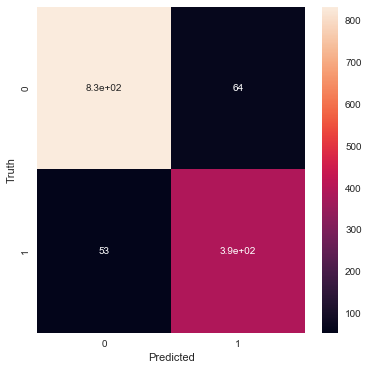

In [55]:
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

## Calculating the multi-class metrics

In [56]:
from sklearn import metrics
print(metrics.classification_report(y_actual, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       896
           1       0.86      0.88      0.87       443

    accuracy                           0.91      1339
   macro avg       0.90      0.90      0.90      1339
weighted avg       0.91      0.91      0.91      1339

